# MountainCar-v0

## Components

### Libraries

In [1]:
!pip install keras-rl2
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

     |████████████████████████████████| 61kB 3.5MB/s 


In [2]:
from gym.envs.classic_control.mountain_car import MountainCarEnv
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, MaxBoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger
from rl.agents import DQNAgent
from rl.callbacks import Callback
from colabgymrender.recorder import Recorder
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from collections import defaultdict
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import json
import gym
import random
from time import time
from itertools import product

print(f'tensorflow version = {tf.__version__}')
print(tf.config.list_physical_devices('GPU'))
print()

np.random.seed(0)
random.seed(0)

# FIXME
display = Display(visible=0, size=(400, 300))
display.start()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2088960/45929032 bytes (4.5%)5111808/45929032 bytes (11.1%)8069120/45929032 bytes (17.6%)10936320/45929032 bytes (23.8%)13688832/45929032 bytes (29.8%)16572416/45929032 bytes (36.1%)19636224/45929032 bytes (42.8%)22773760/45929032 bytes (49.6%)25853952/45929032 bytes (56.3%)28622848/45929032 bytes (62.3%)31481856/45929032 bytes (68.5%)33890304/45929032 bytes (73.8%)

### Environment

In [3]:
class MountainCarWithNoiseEnv(MountainCarEnv):
    def __init__(self, goal_velocity=0, sigma=0):
        super().__init__(goal_velocity)
        self.sigma = sigma

    def step(self, action):
        state, reward, done, info = super().step(action)
        
        if self.sigma > 0:
            state[0] += np.random.normal(0, self.sigma)
            state[1] += np.random.normal(0, self.sigma)
        
        return state, reward, done, info

### Neural Network

In [4]:
def get_model(env):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(env.action_space.n))
    
    return model

### Agent

In [5]:
def run_experiment(enable_double_dqn, policy_name, policy, sigma):
    t0 = time()

    env = MountainCarWithNoiseEnv(sigma=sigma)
    
    env.seed(0)
    np.random.seed(0)
    
    model = get_model(env)
    
    agent = DQNAgent(model=model,
                     nb_actions=env.action_space.n, 
                     memory=SequentialMemory(limit=50000, window_length=1), 
                     nb_steps_warmup=50, 
                     target_model_update=1e-2, 
                     policy=policy,
                     enable_double_dqn=enable_double_dqn)
        
    agent.compile(keras.optimizers.Adam(lr=1e-3), metrics=['mae'])

    results_file_name = get_results_file_name(enable_double_dqn, policy_name, sigma)
    agent.fit(env, nb_steps=150000, nb_max_episode_steps=200, verbose=0,
              callbacks=[FileLogger(results_file_name)])

    env.close()

    print(f'Total time: {(time() - t0)/60:.1f} min')

### Plots

In [6]:
from google.colab import drive
drive.mount('/content/drive')

MAIN_DIR = '/content/drive/MyDrive/'

Mounted at /content/drive


In [7]:
def get_experiment(enable_double_dqn, policy_name, sigma):
    agent_name = 'DDQN' if enable_double_dqn else 'DQN'
    return agent_name + ' ' + policy_name + f' sigma={sigma}'

def get_results_file_name(enable_double_dqn, policy_name, sigma):
    return MAIN_DIR + get_experiment(enable_double_dqn, policy_name, sigma) + '.json'

def exponential_smoothing(x, alpha):
    y = np.zeros_like(x)
    
    y[0] = x[0]
    
    for i in range(1, len(x)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    
    return y

def plot_results(enable_double_dqns, policy_names, sigmas):
    if type(enable_double_dqns) != list: enable_double_dqns = [enable_double_dqns]
    if type(policy_names) != list: policy_names = [policy_names]
    if type(sigmas) != list: sigmas = [sigmas]

    plt.figure(figsize=(8, 6))
    plt.title('Mean reward per episode (smooth)')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    for enable_double_dqn, policy_name, sigma in product(enable_double_dqns, policy_names, sigmas):
        results_file_name = get_results_file_name(enable_double_dqn, policy_name, sigma)     
        with open(results_file_name, 'r') as f:
            results = json.load(f)
        episodes = results['episode']
        rewards = results['episode_reward']
        rewards = exponential_smoothing(rewards, 0.01)
        experiment = get_experiment(enable_double_dqn, policy_name, sigma)
        plt.plot(episodes, rewards, label=experiment)
    plt.legend()
    plt.show()
    print()

    plt.figure(figsize=(8, 6))
    plt.title('Mean Q per episode')
    plt.xlabel('Episodes')
    plt.ylabel('Q')
    for enable_double_dqn, policy_name, sigma in product(enable_double_dqns, policy_names, sigmas):
        results_file_name = get_results_file_name(enable_double_dqn, policy_name, sigma)     
        with open(results_file_name, 'r') as f:
            results = json.load(f)
        episodes = results['episode']
        rewards = results['mean_q']
        experiment = get_experiment(enable_double_dqn, policy_name, sigma)
        plt.plot(episodes, rewards, label=experiment)
    plt.legend()
    plt.show()
    print()

## Experiments

### DQN EpsGreedy 

In [8]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(), 0)

Total time: 25.4 min


In [9]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(), 0.002)

Total time: 25.9 min


In [10]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(), 0.004)

Total time: 26.3 min


In [11]:
run_experiment(False, 'EpsGreedy', EpsGreedyQPolicy(), 0.006)

Total time: 26.9 min


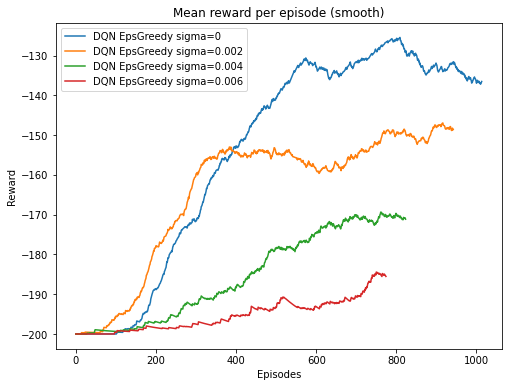

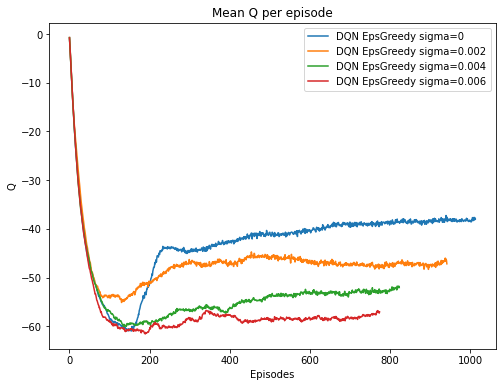

In [18]:
plot_results(False, 'EpsGreedy', [0, 0.002, 0.004, 0.006])

### DDQN EpsGreedy 

In [19]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(), 0)

Total time: 30.1 min


In [20]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(), 0.002)

Total time: 30.6 min


In [21]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(), 0.004)

Total time: 31.2 min


In [22]:
run_experiment(True, 'EpsGreedy', EpsGreedyQPolicy(), 0.006)

Total time: 31.8 min


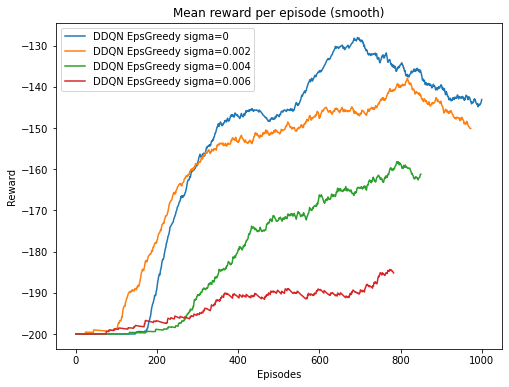

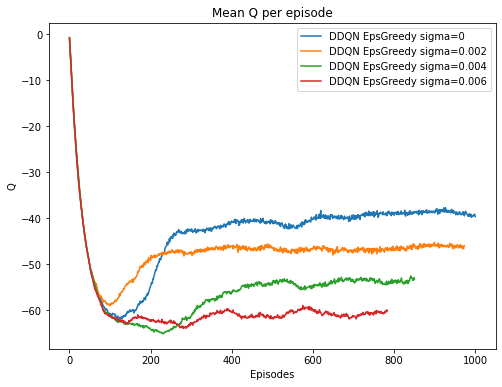

In [23]:
plot_results(True, 'EpsGreedy', [0, 0.002, 0.004, 0.006])

### DQN MaxBoltzmann 

In [24]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0)

Total time: 29.9 min


In [25]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0.002)

Total time: 30.4 min


In [26]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0.004)

Total time: 31.0 min


In [8]:
run_experiment(False, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0.006)

Total time: 19.7 min


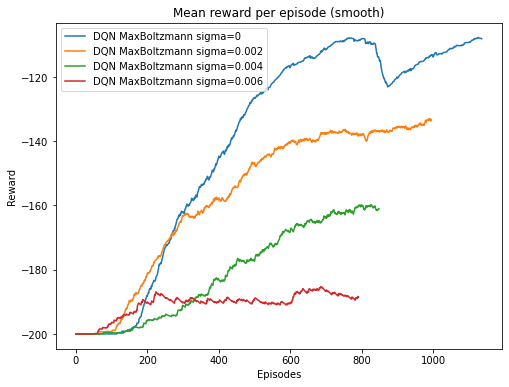

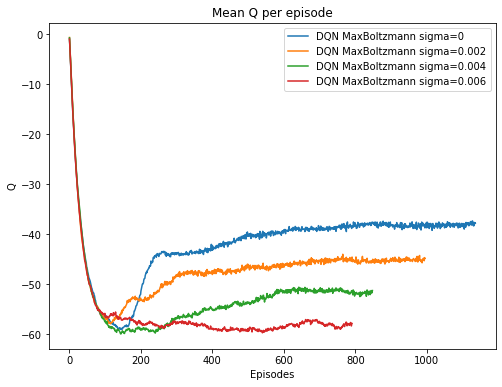

In [9]:
plot_results(False, 'MaxBoltzmann', [0, 0.002, 0.004, 0.006])

### DDQN MaxBoltzmann 

In [10]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0)

Total time: 21.9 min


In [11]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0.002)

Total time: 23.1 min


In [12]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0.004)

Total time: 24.0 min


In [13]:
run_experiment(True, 'MaxBoltzmann', MaxBoltzmannQPolicy(), 0.006)

Total time: 24.4 min


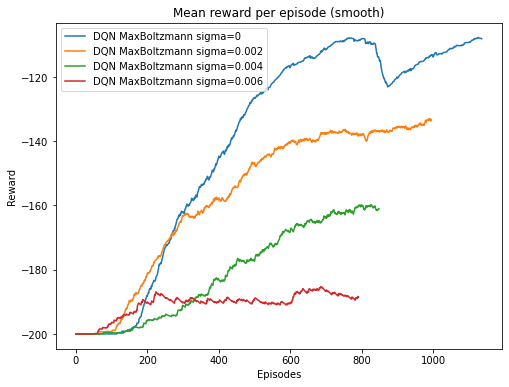

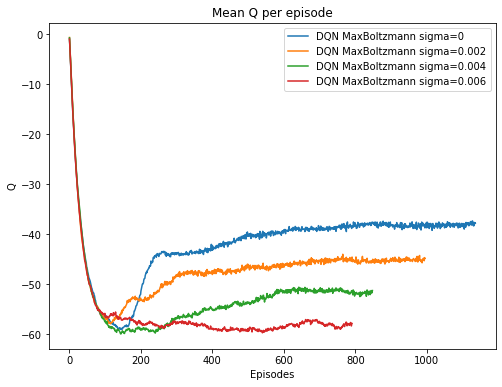

In [14]:
plot_results(False, 'MaxBoltzmann', [0, 0.002, 0.004, 0.006])

### Results per sigma

#### sigma=0

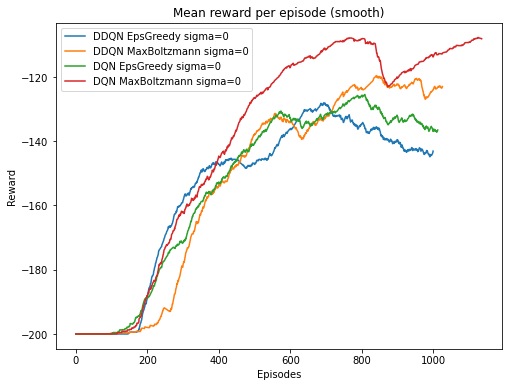

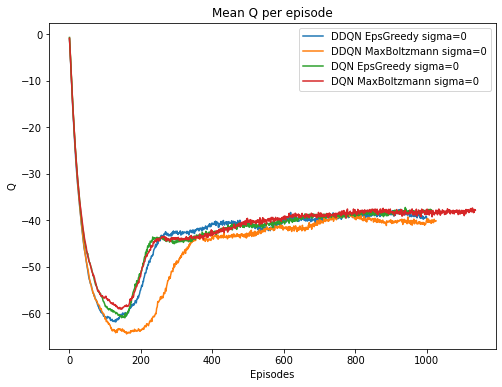

In [15]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0)

#### sigma=0.002

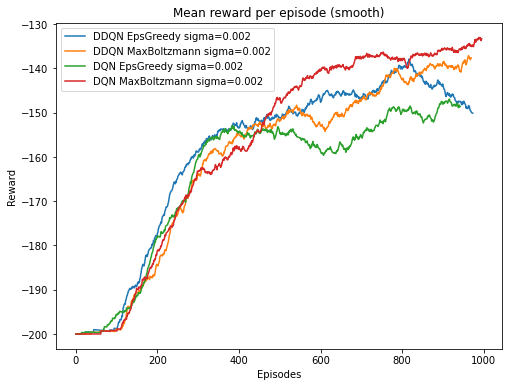

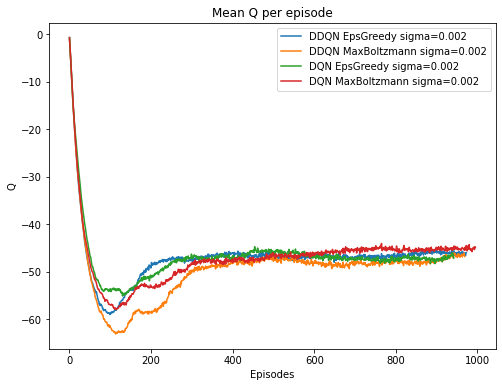

In [16]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0.002)

#### sigma=0.004

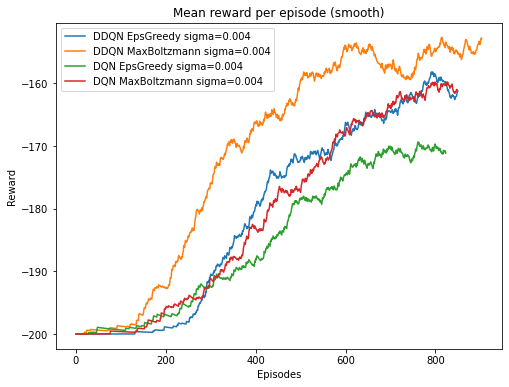

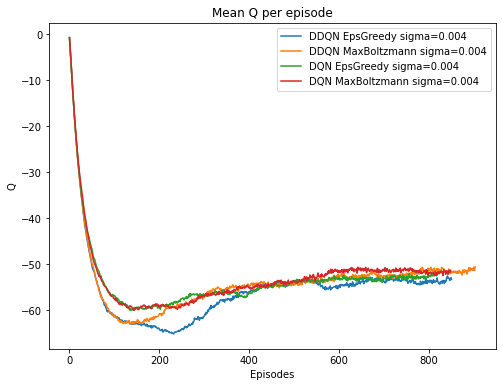

In [17]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0.004)

#### sigma=0.006

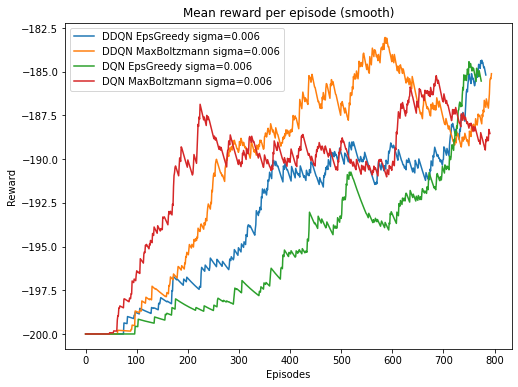

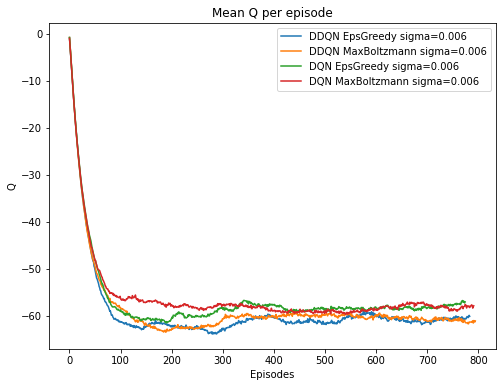

In [18]:
plot_results([True, False], ['EpsGreedy', 'MaxBoltzmann'], 0.006)